# Cate inference Practice (Causalml-Book)

- This is a concise introduction to Chapter 14 of the [CausalML(2022)](https://causalml-book.org/) Notebook. (Some of my thoughts are included) For readability, some cells are hidden, but you can run the code by downloading the ipynb file. This practice refers to the paper by {cite}`10.1093/poq/nfs036`. It explores the sentiment of American citizens towards the word "Welfare" using survey data.
- The survey subjects are divided into two groups and receive similar but different questions. In particular, it includes questions like "Do you think the government spends too much money on Welfare?" and "Do you think the government spends too much money on Assistance to the Poor?" The survey results show that more people responded affirmatively to the former. (ATE level)
- Furthermore, we practice CATE estimation to see how the effect of varying questions differs according to progressive tendencies, education levels, etc.

# Setup

In [ ]:
!pip install econml

# hide

In [ ]:
!pip install wget

# hide

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.api import OLS
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
import pandas as pd

# hide

In [16]:
import wget
import os

if os.path.exists('datasets.py'):
    os.remove('datasets.py')
wget.download('https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/T/datasets.py')

if os.path.exists('myxgb.py'):
    os.remove('myxgb.py')
wget.download('https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/T/myxgb.py')

# hide

'myxgb.py'

In [2]:
dataset = 'welfare'
# hide

In [3]:
from datasets import fetch_data_generator

verbose = 0  # Verbosity of auto-ml
n_splits = 5  # Cross-Fitting and Cross-Validation Splits
cfit = True
data = 'welfare'  # Which Dataset, One of {'401K', 'Criteo', 'WELFARE', 'POVERTY', 'Charity'}
plot = True  # wheat to plot result

control_feats = 'all'  # List of Subset of Features to Be Used As Confounders or the String 'All' for Everything
# List of SubSet of Control Features to Be Used for Cate Model or the String 'All' for All Controls
hetero_feats = 'all'
cov_clip = .01  # Clipping of Treatment variance P (x)*(1-p (x))
binary_y = True
random_seed = 1

# Treatment Policy to Evalue
def policy(x):
    return x['polviews'] > 0

# For SEMI-Synthetic Data Generation
semi_synth = False  # Whether True Outcome Y SHOULD Be Replaced by a Fake Outcome from a Known CEF
simple_synth = True  # Whether the True CEF of the Fake Y SHOULD Be Simple or Fitted from Data
max_depth = 2  # max depth of Random Forest During for Semi-Synthetic Model Fitting
scale = .2  # Magnitude of Noise in SEMI-SYNTHETIC DATA


def simple_true_cef(D, X):  # Simple CEF of the Outcome for Semi-Synthetic Data
    return .5 * np.array(X)[:, 1] * D + np.array(X)[:, 1]

get_data, _, _, _ = fetch_data_generator(data=data, semi_synth=semi_synth, simple_synth=simple_synth, scale=scale, true_f=simple_true_cef, max_depth=max_depth)
# hide

In [4]:
# Fetching Dataset
X, D, y, _ = get_data()

Y is the dependent or target variable, D is the variable of interest or treatment variable (whether the wording 'assistance to the poor' was used), and X can be thought of as nuisance variables. We only want to know the causal relationship between Y and D, but we have all three because bias would occur if we don't consider X.

(This is in contrast to prediction models where we only divide into Y (Target Variable) and X (Features).)

In [5]:
D # Here D = 1 means assistance to the poor, D = 0 means welfare wording

array([0, 1, 1, ..., 1, 0, 1])

In [6]:
y # For the statement 'I think the government spends too much money on welfare/assistance to the poor': Yes = 1, No = 0

array([1, 0, 0, ..., 0, 1, 0])

# Data Analysis and Simple OLS

In [7]:
X.head()

,hrs1,income,rincome,age,polviews,educ,earnrs,sibs,childs,occ80,...,marital_2.0,marital_3.0,marital_4.0,marital_5.0,race_2,race_3,mobile16_2.0,mobile16_3.0,sex_2,born_2.0
15617,60.0,12.0,11.0,47.0,4.0,18.0,3.0,0.0,3.0,869.0,...,False,False,False,False,False,False,False,True,False,False
15902,35.0,12.0,12.0,26.0,5.0,12.0,1.0,3.0,0.0,505.0,...,False,False,False,True,False,True,False,True,False,False
17984,40.0,12.0,12.0,28.0,4.0,16.0,1.0,2.0,0.0,19.0,...,False,False,False,True,False,False,True,False,False,False
5242,25.0,12.0,8.0,21.0,4.0,12.0,2.0,1.0,0.0,276.0,...,False,False,False,True,False,False,False,False,False,False
21557,45.0,12.0,12.0,60.0,3.0,12.0,2.0,0.0,3.0,19.0,...,False,False,False,False,False,False,True,False,False,False


In [8]:
X.describe() # AMONG THESE, PolViews Represents Political Views, with Values ​​from 1 to 7 Becoming more conservative.

,hrs1,income,rincome,age,polviews,educ,earnrs,sibs,childs,occ80,...,reg16,family16,parborn,maeduc,degree,hompop,babies,preteen,teens,adults
count,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,...,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000
mean,42.260324,11.305183,10.223367,40.573952,4.083443,14.026497,1.745177,3.426823,1.569613,332.056016,...,4.417758,1.824669,0.886263,11.745874,1.758736,2.645619,0.227628,0.303479,0.216782,1.893004
std,14.018162,1.635527,2.744435,12.179377,1.376485,2.722665,0.830837,2.918114,1.482378,242.739687,...,2.619726,1.662529,2.418884,3.313779,1.177910,1.399372,0.546265,0.656729,0.527373,0.774679
min,0.000000,1.000000,1.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,38.000000,12.000000,9.000000,31.000000,3.000000,12.000000,1.000000,2.000000,0.000000,156.000000,...,2.000000,1.000000,0.000000,11.000000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000
50%,40.000000,12.000000,12.000000,40.000000,4.000000,14.000000,2.000000,3.000000,2.000000,305.000000,...,4.000000,1.000000,0.000000,12.000000,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000
75%,50.000000,12.000000,12.000000,49.000000,5.000000,16.000000,2.000000,4.000000,2.000000,458.000000,...,6.500000,1.000000,0.000000,13.000000,3.000000,4.000000,0.000000,0.000000,0.000000,2.000000
max,89.000000,12.000000,12.000000,88.000000,7.000000,20.000000,8.000000,37.000000,8.000000,889.000000,...,9.000000,8.000000,8.000000,20.000000,4.000000,11.000000,4.000000,5.000000,4.000000,8.000000


In [9]:
X = X - X.mean(axis=0)

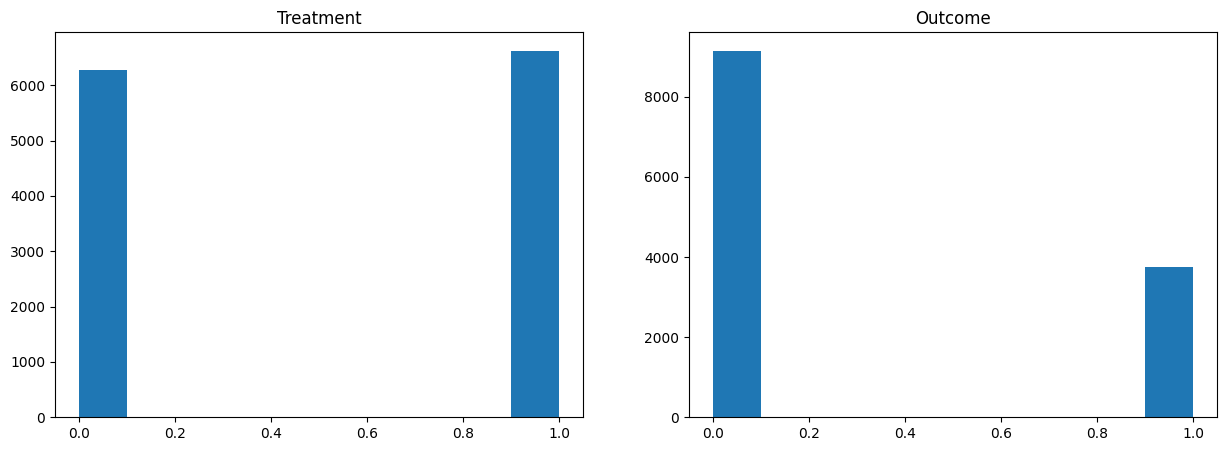

In [28]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(D)
plt.title('Treatment')
plt.subplot(1, 2, 2)
plt.hist(y)
plt.title('Outcome')
plt.show()

In [29]:
import statsmodels.formula.api as smf

model = smf.ols(formula="y ~ D", data=X).fit(cov_type='HC1')
print(model.summary())

# If not a Random Trial, Selection Bias cannot be excluded by this method.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     2476.
Date:                Sat, 22 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:33:58   Log-Likelihood:                -6969.7
No. Observations:               12907   AIC:                         1.394e+04
Df Residuals:                   12905   BIC:                         1.396e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4798      0.006     76.111      0.0

# Doubles-Robust Ate Estimation and CATE Estimation

## Define and Estimate

Before definition of Doubles-Robust Estimator, we will define some functions and estimates. We can create a model that predicts y with all variables (x and d = 0) inside the Control Group with d = 0. Like D = 1, you can create a model. If the two groups are comparable, this may be a good model. (Of course, in some Learners, there may be a chance of being undertected even though it is a policy that creates a predictive value by relying only on X, without considering the effect of 0 or 1 due to the level of covariates.)

\begin{align}
g_0 (x): = E [Y \mid D = 0, X = x] \\
g_1 (x): = E [Y \mid D = 1, X = x] \\
g_{D_i} (x): = g_1 (x) * D + g_0 (x) * (1 - D) \\
\end{align}


You can also make the propensity score model P (x) as follows. Q (x) is a model that predicts Y without using D variable. (It is used for the elementalization method used in DML or CAUSAL FOREST.)

\begin{align}
p(x): = E [D \mid X = x] = \ Pr (D = 1 \mid X = x) \\
q(x): = E [Y \mid X = x] \\
\end{align}

To get all the estimates described here, you can use the desired machine learning. However, when using this method due to over-fitting problems, one rule is to do Cross-Validation. This notebook usually uses xgboost regression.

Now you can estimate the ATE by creating a $Y_i^{DR}$ function as shown below and finding the expected value. The reason why it is called Double Robust is that even if the $\hat{p}(x_i)$ is inaccurate, even if $\hat{g}_1(x_i)$ and $\hat{g}_0(x_i)$ are inaccurate, if the propensity scores estimate $\hat{p}(x_i)$, the same value is the right ATE.

The Doubly Robust Estimator is defined as follows:

\begin{align}
Y_i^{DR}(\hat{g},\hat{p}) := \hat{g}_1(X_i) - \hat{g}_0(X_i) + (Y_i - \hat{g}_{D_i}(X_i))\frac{D_i - \hat{p}(X_i)}{\hat{p}(X_i) (1-\hat{p}(X_i))}
\end{align}

After that, it can be used as follows:

\begin{align}
ATE = E_n\left[Y^{DR}(\hat{g},\hat{p})\right], CATE = \tau(X) = E[Y^{DR}(\hat{g}, \hat{p})|X]
\end{align}

Please refer to [link](/doubly-robust-estimator) for proof.

In [30]:
# Using a function created by the author. XGBOOST does not provide 0/1 binary classification, so wrapper is made separately.

from myxgb import xgb_reg, xgb_clf, RegWrapper

def auto_reg():
    return xgb_reg(random_seed)

def auto_clf():
    return RegWrapper(xgb_clf(random_seed))

modely = auto_clf if binary_y else auto_reg

In [31]:
if cfit:
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    stratification_label = 2 * D + y if binary_y else D
    splits = list(cv.split(X, stratification_label))
else:
    splits = [(np.arange(X.shape[0]), np.arange(X.shape[0]))]

n = X.shape[0]
reg_preds_t = np.zeros(n)
reg_zero_preds_t = np.zeros(n)
reg_one_preds_t = np.zeros(n)

for train, test in splits:
    reg_zero = modely().fit(X.iloc[train][D[train] == 0], y[train][D[train] == 0]) 
    reg_one = modely().fit(X.iloc[train][D[train] == 1], y[train][D[train] == 1]) 
    
    reg_zero_preds_t[test] = reg_zero.predict(X.iloc[test]) # (Y ~ x | d == 0), xgboost
    reg_one_preds_t[test] = reg_one.predict(X.iloc[test]) # (Y ~ x | d == 1), xgBoost
    reg_preds_t[test] = reg_zero_preds_t[test] * (1 - D[test]) + reg_one_preds_t[test] * D[test] # COMBINE Above Two

res_preds = cross_val_predict(modely(), X, y, cv=splits) # (Y ~ x) with CV, xgboost
prop_preds = cross_val_predict(auto_clf(), X, D, cv=splits) # (D ~ x) with CV, XGBOOST

In [32]:
def r2score(y, ypred):
    return 1 - np.mean((y - ypred)**2) / np.var(y)

print(f"R^2 of model for (y ~ X): {r2score(y, res_preds):.4f}")
print(f"R^2 of model for (D ~ X): {r2score(D, prop_preds):.4f}")
print(f"R^2 of model for (y ~ X | D==0): {r2score(y[D==0], reg_zero_preds_t[D==0]):.4f}")
print(f"R^2 of model for (y ~ X | D==1): {r2score(y[D==1], reg_one_preds_t[D==1]):.4f}")
print(f"R^2 of model for (y ~ X, D): {r2score(y, reg_preds_t):.4f}")

R^2 of model for (y ~ X): 0.0458
R^2 of model for (D ~ X): -0.0002
R^2 of model for (y ~ X | D==0): 0.0690
R^2 of model for (y ~ X | D==1): 0.0375
R^2 of model for (y ~ X, D): 0.2140


## ATE

In [33]:
dr_preds = reg_one_preds_t - reg_zero_preds_t
dr_preds += (y - reg_preds_t) * (D - prop_preds) / np.clip(prop_preds * (1 - prop_preds), cov_clip, np.inf)

ate = np.mean(dr_preds)
print(f"ATE: {ate:.4f}")

ATE: -0.3660


## CATE

### (1) Just estimate

If we turn the $Y^{DR}$ as a dependent variable, we can get the CATE. The explanation of the output results of the output results estimates how much ATE is increasing if the X1 increases, for example. If the CATE is larger, it can be interpreted as the effect of the policy as the variable increases. If it's RCT, you'll get a value that's almost the same as the second coefficient from y ~ D + D * x1.

In [34]:
dfX = X.copy()
dfX['const'] = 1
lr = OLS(dr_preds, dfX).fit(cov_type='HC1')
cov = lr.get_robustcov_results(cov_type='HC1')
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     5.090
Date:                Sat, 22 Mar 2025   Prob (F-statistic):           1.29e-24
Time:                        15:34:00   Log-Likelihood:                -15618.
No. Observations:               12907   AIC:                         3.132e+04
Df Residuals:                   12864   BIC:                         3.164e+04
Df Model:                          42                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
hrs1            -0.0018      0.001     -2.679   

In [35]:
# Get the CATE of the Income with OLS and see if it is similar.

df_cate_by_ols = X.copy()
df_cate_by_ols['y'] = y
df_cate_by_ols['D'] = D
df_cate_by_ols['D_income'] = D * df_cate_by_ols["income"]
model = smf.ols(formula="y ~ D + income + D_income", data=df_cate_by_ols).fit(cov_type='HC1')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     857.8
Date:                Sat, 22 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:34:00   Log-Likelihood:                -6933.5
No. Observations:               12907   AIC:                         1.388e+04
Df Residuals:                   12903   BIC:                         1.390e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4795      0.006     76.345      0.0

Cate for Income. The OLS coefficient and value of the Income for DOUBLY ROBUST Y estimates are almost the same as expected.

### (2) Estimating CATE with Confidence Interval

Below is to look at the CATE with Confidence Interval based on Joint Inference.

In [36]:
V = cov.cov_params()
S = np.diag(np.diagonal(V)**(-1 / 2))
epsilon = np.random.multivariate_normal(np.zeros(V.shape[0]), S @ V @ S, size=(1000))
critical = np.percentile(np.max(np.abs(epsilon), axis=1), 95)
stderr = np.diagonal(V)**(1 / 2)
lb = cov.params - critical * stderr
ub = cov.params + critical * stderr
jointsummary = pd.DataFrame({'coef': cov.params,
                             'std err': stderr,
                             'lb': lb,
                             'ub': ub,
                             'statsig': ['' if ((l <= 0) & (0 <= u)) else '**' for (l, u) in zip(lb, ub)]},
                            index=dfX.columns)
jointsummary

,coef,std err,lb,ub,statsig
hrs1,-0.001809,0.000675,-0.003996,0.000377,
income,-0.011030,0.005612,-0.029202,0.007142,
rincome,-0.004747,0.003779,-0.016984,0.007491,
age,0.000504,0.000840,-0.002215,0.003223,
polviews,-0.021687,0.005975,-0.041034,-0.002341,**
educ,0.000293,0.005695,-0.018146,0.018732,
earnrs,0.006672,0.012223,-0.032905,0.046249,
sibs,0.002066,0.002696,-0.006665,0.010797,
childs,0.004955,0.006842,-0.017198,0.027108,
occ80,-0.000053,0.000042,-0.000190,0.000083,


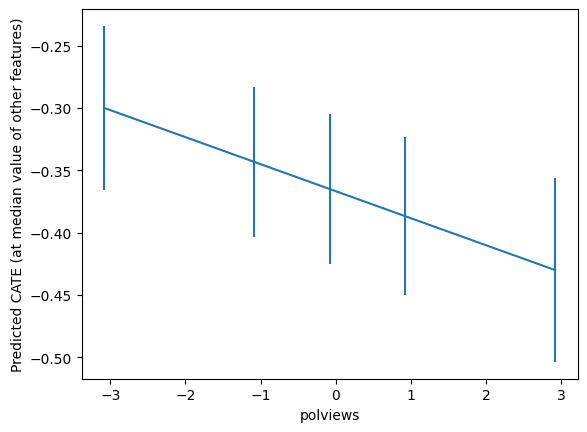

In [37]:
grid = np.unique(np.percentile(dfX['polviews'], np.arange(0, 110, 20)))

Zpd = pd.DataFrame(np.tile(np.median(dfX, axis=0, keepdims=True), (len(grid), 1)),
                   columns=dfX.columns)
Zpd['polviews'] = grid

pred_df = lr.get_prediction(Zpd).summary_frame()
preds, lb, ub = pred_df['mean'].values, pred_df['mean_ci_lower'].values, pred_df['mean_ci_upper'].values
preds = preds.flatten()
lb = lb.flatten()
ub = ub.flatten()
plt.errorbar(Zpd['polviews'], preds, yerr=(preds - lb, ub - preds))
plt.xlabel('polviews')
plt.ylabel('Predicted CATE (at median value of other features)')
plt.show()

# Simpler Best Linear Projections of Cate

These are also possible.

1. There are seven different values ​​of PolViews, and each value can see CATE and Confidence Interval.
2. If PolViews is a continuous variable, I think we can see how the CATE will change.

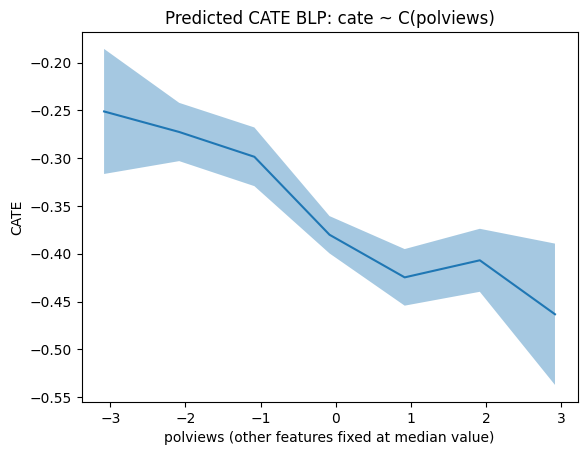

In [38]:
from statsmodels.formula.api import ols
df = X.copy()
df['dr'] = dr_preds
lr = ols('dr ~ C(polviews)', df).fit(cov_type='HC1')

grid = np.unique(np.percentile(X['polviews'], np.arange(0, 102, 2)))
Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                   columns=X.columns)
Xpd['polviews'] = grid
pred_df = lr.get_prediction(Xpd).summary_frame(alpha=.1)

plt.plot(Xpd['polviews'], pred_df['mean'])
plt.fill_between(Xpd['polviews'], pred_df['mean_ci_lower'], pred_df['mean_ci_upper'], alpha=.4)
plt.xlabel('polviews' + ' (other features fixed at median value)')
plt.title('Predicted CATE BLP: cate ~ C(polviews)')
plt.ylabel('CATE')
plt.show()

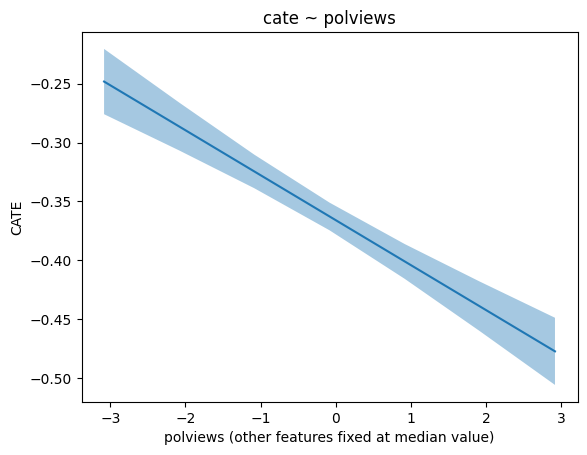

In [39]:
from statsmodels.formula.api import ols
df = X.copy()
df['dr'] = dr_preds
lr = ols('dr ~ polviews', df).fit(cov_type='HC1')

grid = np.unique(np.percentile(X['polviews'], np.arange(0, 102, 2)))
Xpd = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                   columns=X.columns)
Xpd['polviews'] = grid
pred_df2 = lr.get_prediction(Xpd).summary_frame(alpha=.1)

plt.plot(Xpd['polviews'], pred_df2['mean'])
plt.fill_between(Xpd['polviews'], pred_df2['mean_ci_lower'], pred_df2['mean_ci_upper'], alpha=.4)
plt.xlabel('polviews' + ' (other features fixed at median value)')
plt.ylabel('CATE')
plt.title('cate ~ polviews' )
plt.show()

# Non-parametric confidence intervals on cate predictions

Let's not like a linear model, but now let's predict nonparametric CATE. Usually uses access called Causal Forests or Doubly Robust Forests.

## Causal Forests

In [40]:
Z = X

In [41]:
min_samples_leaf = 50
max_samples = .4

In [42]:
from econml.grf import CausalForest

yres = y - res_preds # Res_PREDS: (y ~ x) with CV, xgboost
Dres = D - prop_preds # Prop_PREDS: (D ~ X) with CV, XGBOOST
cf = CausalForest(4000, criterion='het', max_depth=None,
                  max_samples=.4,
                  min_samples_leaf=50,
                  min_weight_fraction_leaf=.0,
                  random_state=random_seed)
cf.fit(Z, Dres, yres)

CausalForest(criterion='het', max_samples=0.4, min_samples_leaf=50,
             n_estimators=4000, random_state=1)

In [43]:
top_feat = np.argsort(cf.feature_importances_)[-1]
print(Z.columns[top_feat])

polviews


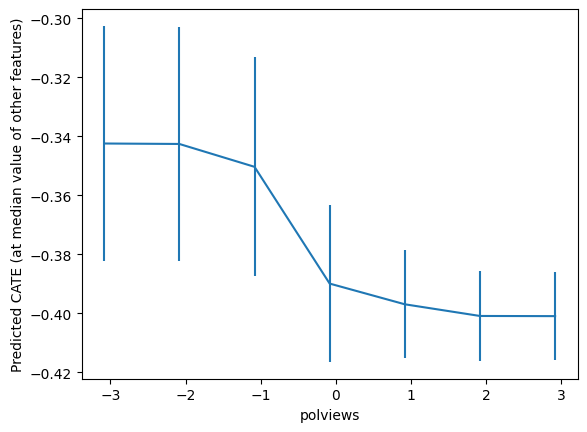

In [44]:
grid = np.unique(np.percentile(Z.iloc[:, top_feat], np.arange(0, 105, 5)))
Zpd = pd.DataFrame(np.tile(np.median(Z, axis=0, keepdims=True), (len(grid), 1)),
                   columns=Z.columns)
Zpd.iloc[:, top_feat] = grid

preds, lb, ub = cf.predict(Zpd, interval=True, alpha=.1)
preds = preds.flatten()
lb = lb.flatten()
ub = ub.flatten()
plt.errorbar(Zpd.iloc[:, top_feat], preds, yerr=(preds - lb, ub - preds))
plt.xlabel(Zpd.columns[top_feat])
plt.ylabel('Predicted CATE (at median value of other features)')
plt.show()

In [45]:
important_feats = Z.columns[np.argsort(cf.feature_importances_)[::-1]]
important_feats[:4]

Index(['polviews', 'indus80', 'educ', 'hrs1'], dtype='object')

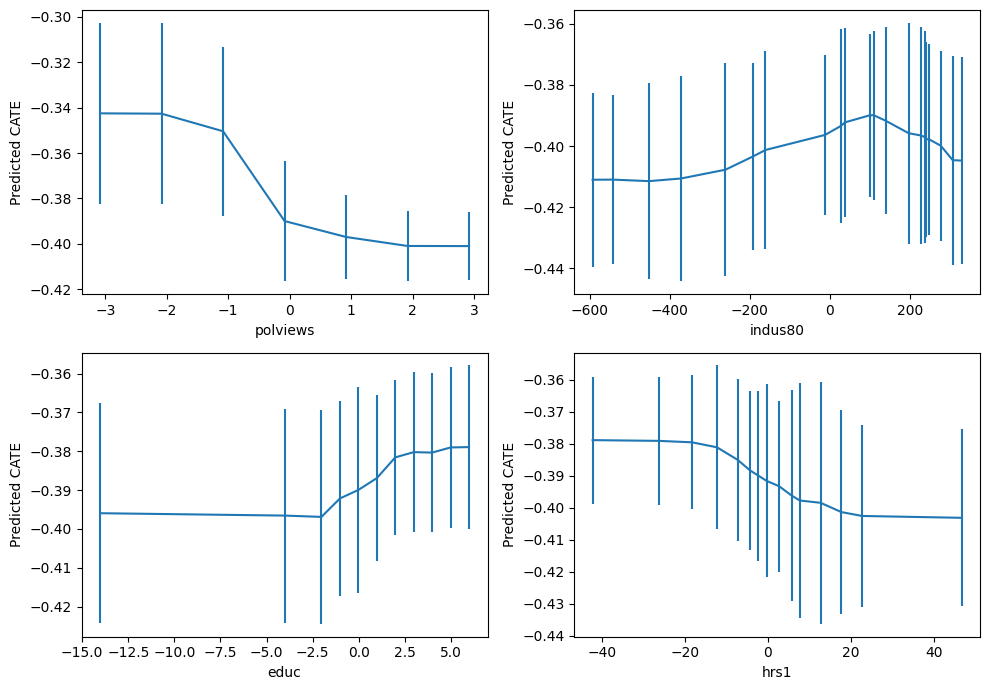

In [46]:
plt.figure(figsize=(10, 7))
for it, feature in enumerate(important_feats[:4]):
    plt.subplot(2, 2, it + 1)
    grid = np.unique(np.percentile(Z[feature], np.arange(0, 105, 5)))
    Zpd = pd.DataFrame(np.tile(np.median(Z, axis=0, keepdims=True), (len(grid), 1)),
                       columns=Z.columns)
    Zpd[feature] = grid

    preds, lb, ub = cf.predict(Zpd, interval=True, alpha=.1)
    preds = preds.flatten()
    lb = lb.flatten()
    ub = ub.flatten()
    plt.errorbar(Zpd[feature], preds, yerr=(preds - lb, ub - preds))
    plt.xlabel(feature)
    plt.ylabel('Predicted CATE')
plt.tight_layout()
plt.show()

## Double Robust Forests

In [47]:
from econml.grf import RegressionForest

drrf = RegressionForest(4000, max_depth=5,
                        max_samples=.4,
                        min_samples_leaf=50,
                        min_weight_fraction_leaf=.0,
                        random_state=random_seed)
drrf.fit(Z, dr_preds)

RegressionForest(max_depth=5, max_samples=0.4, min_samples_leaf=50,
                 n_estimators=4000, random_state=1)

In [48]:
top_feat = np.argsort(drrf.feature_importances_)[-1]
print(Z.columns[top_feat])

polviews


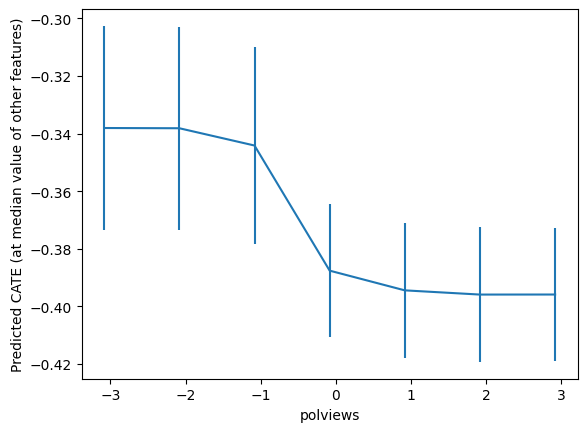

In [49]:
grid = np.unique(np.percentile(Z.iloc[:, top_feat], np.arange(0, 105, 5)))
Zpd = pd.DataFrame(np.tile(np.median(Z.values, axis=0, keepdims=True), (len(grid), 1)),
                   columns=Z.columns)
Zpd.iloc[:, top_feat] = grid

preds, lb, ub = drrf.predict(Zpd, interval=True, alpha=.1)
preds = preds.flatten()
lb = lb.flatten()
ub = ub.flatten()
plt.errorbar(Zpd.iloc[:, top_feat], preds, yerr=(preds - lb, ub - preds))
plt.xlabel(Zpd.columns[top_feat])
plt.ylabel('Predicted CATE (at median value of other features)')
plt.show()

In [50]:
important_feats = Z.columns[np.argsort(drrf.feature_importances_)[::-1]]
important_feats[:4]

Index(['polviews', 'indus80', 'educ', 'hrs1'], dtype='object')

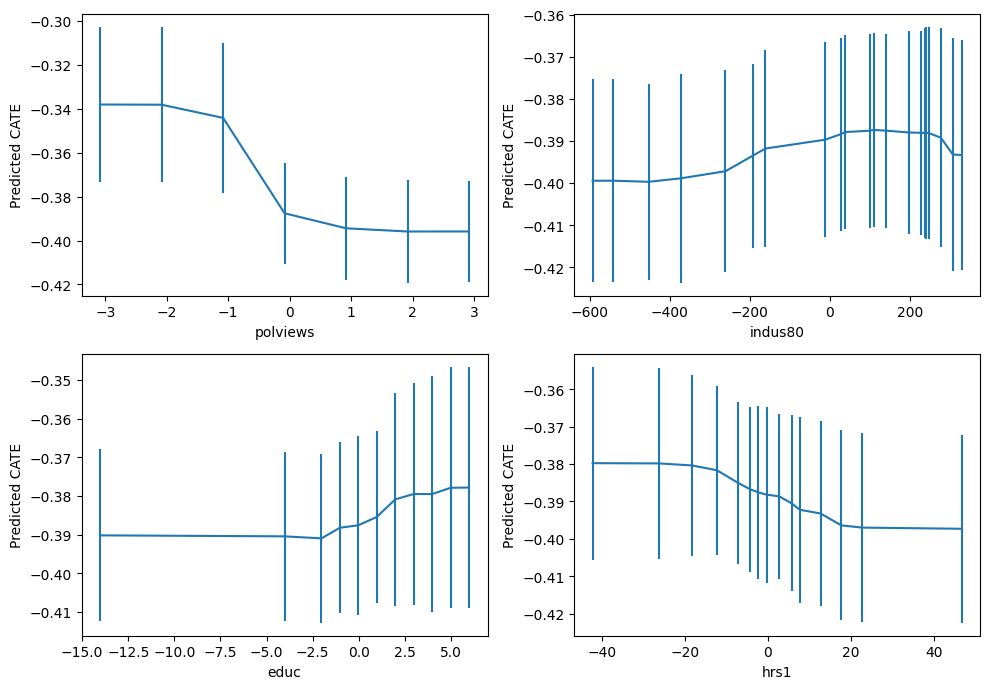

In [51]:
plt.figure(figsize=(10, 7))
for it, feature in enumerate(important_feats[:4]):
    plt.subplot(2, 2, it + 1)
    grid = np.unique(np.percentile(Z[feature], np.arange(0, 105, 5)))
    Zpd = pd.DataFrame(np.tile(np.median(Z, axis=0, keepdims=True), (len(grid), 1)),
                       columns=Z.columns)
    Zpd[feature] = grid

    preds, lb, ub = drrf.predict(Zpd, interval=True, alpha=.1)
    preds = preds.flatten()
    lb = lb.flatten()
    ub = ub.flatten()
    plt.errorbar(Zpd[feature], preds, yerr=(preds - lb, ub - preds))
    plt.xlabel(feature)
    plt.ylabel('Predicted CATE')
plt.tight_layout()
plt.show()

# Policy Evaluation

Let's assume that efforts to change words are expensive to reduce the negative perception of the word 'welfare'. The utility value of Treatment Cost and policy creates a trade-offs relationship. In this case, we will simply put the Treatment Cost in the same unit as the Treatment Effect and make it easier to compare. If it is much more expensive than the ATE -0.36, it will be good to trade only to some of the CATE, and if the cost is not high, it may be better to perform uniform treatment to everyone.

In [52]:
def policy(x):
    return x['polviews'] > 0

#### Low Cost

In [53]:
# Treating by Personized Policy When Cost is Low

treatment_cost = -.3

pi = (dr_preds - treatment_cost) * policy(Z)
score_personalized_low = np.mean(pi)
stderr = np.sqrt(np.var(pi) / pi.shape[0])
print(f"Benefit: {score_personalized_low:.5f}, Standard Error: {stderr:.5f}, 95% CI: {score_personalized_low - 1.96 * stderr:.5f}, {score_personalized_low + 1.96 * stderr:.5f}")

Benefit: -0.04181, Standard Error: 0.00449, 95% CI: -0.05061, -0.03301


In [54]:
# Treating Everyone When Cost is Low

treatment_cost = -.3

pi = (dr_preds - treatment_cost)
score_everyone_low = np.mean(pi)
stderr = np.sqrt(np.var(pi) / pi.shape[0])
print(f"Benefit: {score_everyone_low:.5f}, Standard Error: {stderr:.5f}, 95% CI: {score_everyone_low - 1.96 * stderr:.5f} ~ {score_everyone_low + 1.96 * stderr:.5f}")

Benefit: -0.06601, Standard Error: 0.00720, 95% CI: -0.08012 ~ -0.05191


In [55]:
print("If this cost is low,")
if score_personalized_low < score_everyone_low:
    print("Personalized Treatment is a better policy.")
else:
    print("Treating Everyone is a Better Policy.")

If this cost is low,
Treating Everyone is a Better Policy.


#### High Cost

In [56]:
# Treating by Personized Policy When Cost is High

treatment_cost = -.4

pi = (dr_preds - treatment_cost) * policy(Z)
score_personalized_high = np.mean(pi)
stderr = np.sqrt(np.var(pi) / pi.shape[0])
print(f"Benefit: {score_personalized_high:.5f}, Standard Error: {stderr:.5f}, 95% CI: {score_personalized_high - 1.96 * stderr:.5f} ~ {score_personalized_high + 1.96 * stderr:.5f}")

Benefit: -0.00706, Standard Error: 0.00446, 95% CI: -0.01580 ~ 0.00169


In [57]:
# Treating Everyone When Cost is High

treatment_cost = -.4

pi = (dr_preds - treatment_cost)
score_everyone_high = np.mean(pi)
stderr = np.sqrt(np.var(pi) / pi.shape[0])
print(f"Benefit: {score_everyone_high:.5f}, Standard Error: {stderr:.5f}, 95% CI: {score_everyone_high - 1.96 * stderr:.5f} ~ {score_everyone_high + 1.96 * stderr:.5f}")

Benefit: 0.03399, Standard Error: 0.00720, 95% CI: 0.01988 ~ 0.04809


In [58]:
print("In case where the cost is high,")
if score_personalized_high < score_everyone_high:
    print("Personalized Treatment is a Better Policy.")
else:
    print("Treating Everyone is a Better Policy.")

In case where the cost is high,
Personalized Treatment is a Better Policy.
